# Time Series Analysis and Univariate ARIMA Models

In [1]:
import os
import sys
import warnings
from datetime import date
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import quandl
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load monthly industrial production and daily NASDAQ stock market index:

In [4]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

## Additive Decomposition

Time series data typically contains a mix of various patterns that can be decomposed into several components, each representing an underlying pattern category. In particular, time series often consist of the systematic components trend, seasonality and cycles, and unsystematic noise. These components can be combined in an additive, linear model, in particular when fluctuations do not depend on the level of the series, or in a non-linear, multiplicative model. 

These components can be split up automatically. statsmodels includes a simple method to split the time series into a trend, seasonal, and residual component using moving averages. We can apply it to monthly data on industrial manufacturing production with both a strong trend and seasonality component, as follows:

In [5]:
components = tsa.seasonal_decompose(industrial_production, model='additive')

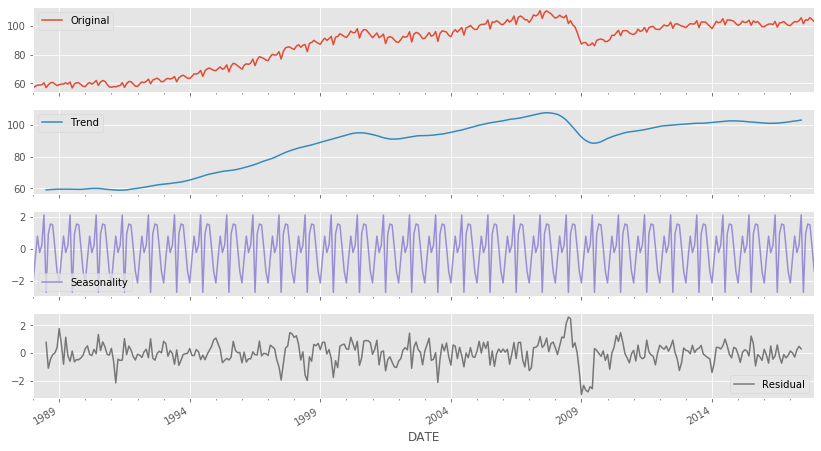

In [6]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
ts.plot(subplots=True, figsize=(14, 8));

## Time Series Stationarity

The statistical properties, such as the mean, variance, or autocorrelation, of a stationary time series are independent of the period, that is, they don't change over time. Hence, stationarity implies that a time series does not have a trend or seasonal effects and that descriptive statistics, such as the mean or the standard deviation, when computed for different rolling windows, are constant or do not change much over time. It reverts to its mean, and the deviations have constant amplitude, while short-term movements always look the same in the statistical sense.

More formally, strict stationarity requires the joint distribution of any subset of time series observations to be independent of time with respect to all moments. So, in addition to the mean and variance, higher moments such as skew and kurtosis, also need to be constant, irrespective of the lag between different observations. In most applications, we limit stationarity to first and second moments so that the time series is covariance stationary with constant mean, variance, and autocorrelation. 

Note that we specifically allow for dependence between observations at different lags, just like we want the input data for linear regression to be correlated with the outcome. Stationarity implies that these relationships are stable, which facilitates prediction as the model can focus on learning systematic patterns that take place within stable statistical properties. It is important because classical statistical models assume that the time series input data is stationary. 

To satisfy the stationarity assumption of linear time series models, we need to transform the original time series, often in several steps. Common transformations include the application of the (natural) logarithm to convert an exponential growth pattern into a linear trend and stabilize the variance. Deflation implies dividing a time series by another series that causes trending behavior, for example dividing a nominal series by a price index to convert it into a real measure.

### Log Transformation

Double check fo zero values

In [7]:
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

In [8]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

In many cases, de-trending is not sufficient to make the series stationary. Instead, we need to transform the original data into a series of period-to-period and/or season-to-season differences. In other words, we use the result of subtracting neighboring data points or values at seasonal lags from each other. Note that when such differencing is applied to a log-transformed series, the results represent instantaneous growth rates or returns in a financial context. 

If a univariate series becomes stationary after differencing d times, it is said to be integrated of the order of d, or simply integrated if d=1. This behavior is due to so-called unit roots.

Differencing of log series produces instantaneous returns.

In [9]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

### Plot Series

The following chart shows time series for the NASDAQ stock index and industrial production for the 30 years through 2017 in original form, as well as the transformed versions after applying the logarithm and subsequently applying first and seasonal differences (at lag 12), respectively. The charts also display the ADF p-value, which allows us to reject the hypothesis of unit-root non-stationarity after all transformations in both cases:

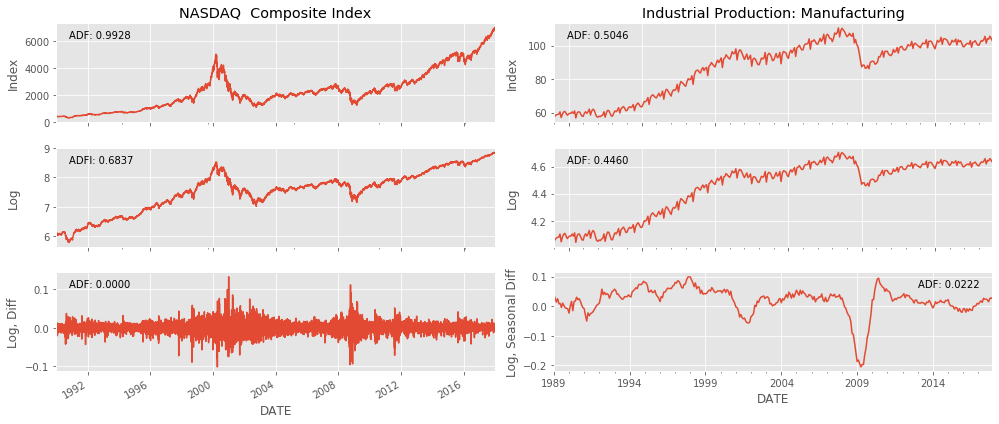

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,6))

nasdaq.plot(ax=axes[0][0], title='NASDAQ  Composite Index')
axes[0][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}', transform=axes[0][0].transAxes)
axes[0][0].set_ylabel('Index')

nasdaq_log.plot(ax=axes[1][0], sharex=axes[0][0])
axes[1][0].text(x=.03, y=.85, s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}', transform=axes[1][0].transAxes)
axes[1][0].set_ylabel('Log')

nasdaq_log_diff.plot(ax=axes[2][0], sharex=axes[0][0])
axes[2][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}', transform=axes[2][0].transAxes)
axes[2][0].set_ylabel('Log, Diff')

industrial_production.plot(ax=axes[0][1], title='Industrial Production: Manufacturing')
axes[0][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}', transform=axes[0][1].transAxes)
axes[0][1].set_ylabel('Index')

industrial_production_log.plot(ax=axes[1][1], sharex=axes[0][1])
axes[1][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}', transform=axes[1][1].transAxes)
axes[1][1].set_ylabel('Log')

industrial_production_log_diff.plot(ax=axes[2][1], sharex=axes[0][1])
axes[2][1].text(x=.83, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}', transform=axes[2][1].transAxes)
axes[2][1].set_ylabel('Log, Seasonal Diff')
fig.tight_layout()
fig.align_ylabels(axes);

## Correlogram

Autocorrelation (also called serial correlation) adapts the concept of correlation to the time series context: just as the correlation coefficient measures the strength of a linear relationship between two variables, the autocorrelation coefficient, $\rho_k$, measures the extent of a linear relationship between time series values separated by a given lag, $k$.

Hence, we can calculate one autocorrelation coefficient for each of the T-1 lags in a time series; T is the length of the series. The autocorrelation function (ACF) computes the correlation coefficients as a function of the lag.
The autocorrelation for a lag larger than 1 (that is, between observations more than one time step apart) reflects both the direct correlation between these observations and the indirect influence of the intervening data points. The partial autocorrelation removes this influence and only measures the linear dependence between data points at the given lag distance. The partial autocorrelation function (PACF) provides all the correlations that result once the effects of a correlation at shorter lags have been removed.

There are algorithms that estimate the partial autocorrelation from the sample autocorrelation based on the exact theoretical relationship between the PACF and the ACF.

A correlogram is simply a plot of the ACF or PACF for sequential lags, k=0,1,...,n. It allows us to inspect the correlation structure across lags at one glance. The main usage of correlograms is to detect any autocorrelation after the removal of the effects of deterministic trend or seasonality. Both the ACF and the PACF are key diagnostic tools for the design of linear time series models and we will review examples of ACF and PACF plots in the following section on time series transformations.

### NASDAQ (log, diff)

We can further analyze the relevant time series characteristics for the transformed series using a Q-Q plot that compares the quantiles of the distribution of the time series observation to the quantiles of the normal distribution and the correlograms based on the ACF and PACF.

For the NASDAQ plot, we notice that while there is no trend, the variance is not constant but rather shows clustered spikes around periods of market turmoil in the late 1980s, 2001, and 2008. The Q-Q plot highlights the fat tails of the distribution with extreme values more frequent than the normal distribution would suggest. The ACF and the PACF show similar patterns with autocorrelation at several lags appearing significant:

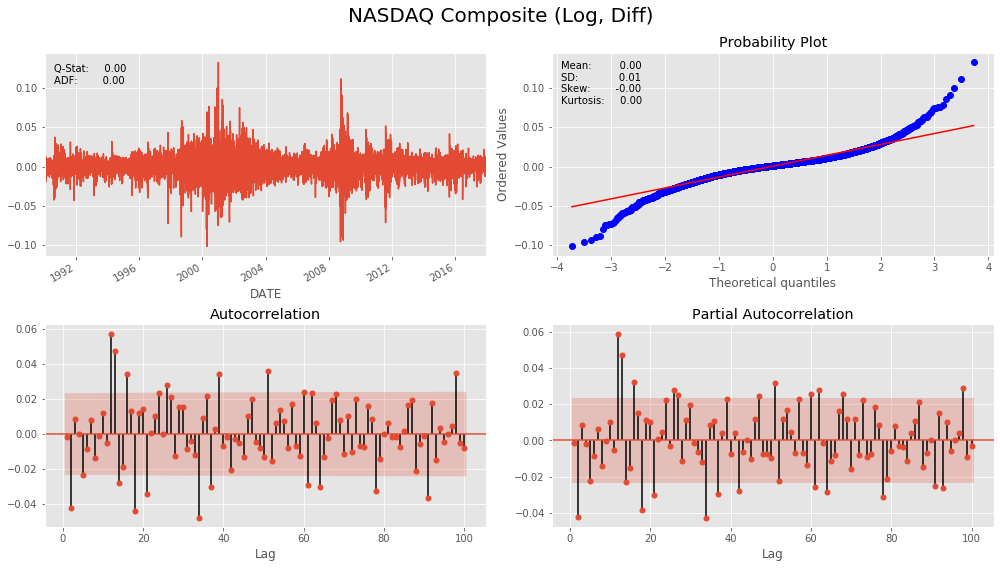

In [11]:
plot_correlogram(nasdaq_log_diff, lags=100, title='NASDAQ Composite (Log, Diff)')

### Industrial Production (log, seasonl diff)

For the monthly time series on industrial manufacturing production, we notice a large negative outlier following the 2008 crisis as well as the corresponding skew in the Q-Q plot. The autocorrelation is much higher than for the NASDAQ returns and declines smoothly. The PACF shows distinct positive autocorrelation patterns at lag 1 and 13, and significant negative coefficients at lags 3 and 4:

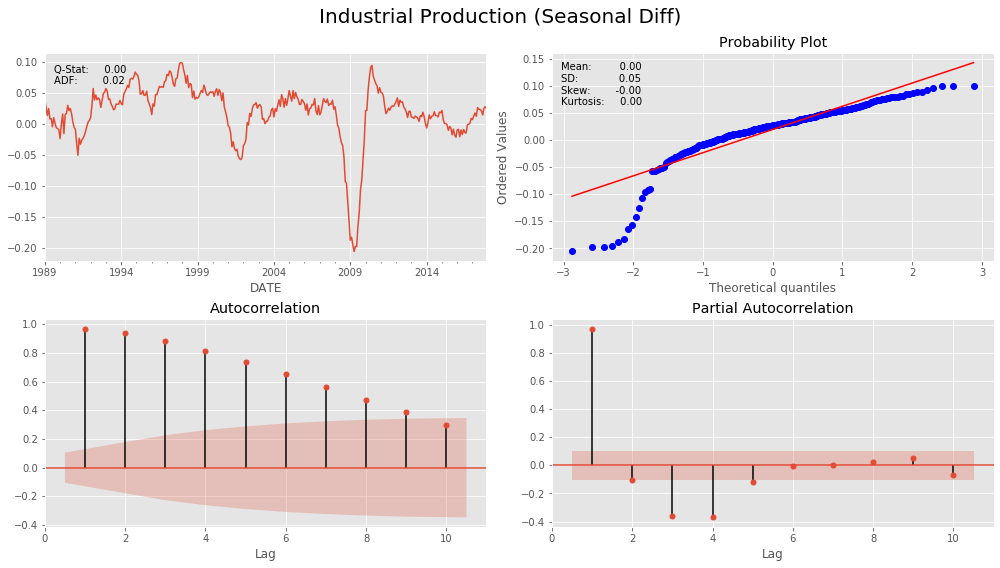

In [12]:
plot_correlogram(industrial_production_log_diff, title='Industrial Production (Seasonal Diff)')

## Univariate Time Series Models

### Autoregressive (AR) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms.
While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:
- Autoregressive (AR) terms consisting of p-lagged values of the time series
- Moving average (MA) terms that contain q-lagged disturbances


Chapter 7 introduces the ARIMA building blocks, simple autoregressive (AR) and moving average (MA) models, and explains how to combine them in autoregressive moving-average (ARMA) models that may account for series integration as ARIMA models or include exogenous variables as AR(I)MAX models. 

Furthermore, we will illustrate how to include seasonal AR and MA terms to extend the toolbox to also include SARMAX models.

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [13]:
model1 = tsa.ARMA(endog=nasdaq_log_diff, order=(2,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

In [14]:
model1.params.sort_index() == model2.params.sort_index().values

ar.L1.NASDAQCOM    True
ar.L2.NASDAQCOM    True
const              True
ma.L1.NASDAQCOM    True
ma.L2.NASDAQCOM    True
dtype: bool

### Seasonal differencing vs SARIMAX

Seasonal differencing has same effect as using SARIMAX w seasonal order (0,1,0,12).

In [15]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

In [16]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.761975,1.765978
ar.L2,-0.784199,-0.788255
ma.L1,-0.841204,-0.859608
ma.L2,0.313329,0.353158
sigma2,0.000101,0.000101


## Finding the optimal ARMA lags

### Run candidate models

We iterate over various (p, q) lag combinations and collect diagnostic statistics to compare the result.

In [17]:
train_size = 120
test_results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        test_results[(p, q)] = [rmse,
                                np.mean(aic),
                                np.mean(bic),
                                convergence_error,
                                stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [18]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']
test_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
RMSE            24 non-null float64
AIC             18 non-null float64
BIC             18 non-null float64
convergence     24 non-null float64
stationarity    24 non-null float64
dtypes: float64(5)
memory usage: 1.2 KB


In [19]:
test_results.dropna()

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.030183 -530.769444 -522.406969          0.0           0.0
  2  0.105961 -598.705151 -587.555184          0.0         107.0
  3  0.031667 -649.864725 -635.927266          0.0          93.0
  4  0.018419 -682.530641 -665.805690          0.0          93.0
1 0  0.011551 -727.389093 -719.026618          0.0           0.0
  1  0.029556 -732.051839 -720.901872          0.0          16.0
  2  0.021869 -743.997434 -730.059975          0.0          10.0
  3  0.018212 -747.753733 -731.028783          0.0           8.0
  4  0.018165 -753.080599 -733.568157          0.0           8.0
2 0  2.736921 -725.216534 -714.066568          0.0           0.0
  2  0.012665 -758.385267 -741.660317          0.0           4.0
  3  0.011741 -759.759816 -740.247374          0.0           3.0
  4  0.043275 -758.573430 -736.273496          0.0          24.0
3 0  0.010585 -747.347746 -733.410287          0.0           0.0
  1  0.011229 -754.383796 -737.658845          0.0           5.0
4 0  0.010008 -758.715127 -741.990177          0.0           0.0
  2  0.013711 -759.329556 -737.029623          0.0           4.0
  3  0.030588 -761.649681 -736.562256          0.0          41.0

We aim to minimize RMSE:

In [20]:
sns.heatmap(test_results.RMSE.unstack().mul(10), fmt='.2', annot=True, cmap='Blues_r');

NameError: name 'sns' is not defined

We also aim to minimize BIC:

In [ ]:
sns.heatmap(test_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues_r');

### Estimating the best ARMA Model

ARMA(0,4) and ARMA(2,2) are close, with a slight edge for the former.

In [ ]:
model = tsa.ARMA(endog=industrial_production_log_diff, order=(0, 4)).fit()
print(model.summary())

### Check Residual Correlogram

In [ ]:
plot_correlogram(model.resid)

## SARIMAX

In [ ]:
model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna(),
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])
print(model.summary())

In [ ]:
plot_correlogram(model.resid)

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecas

### Finding the optimal number of lags

In [ ]:
train_size = 120 # 10 years of training data
test_results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1 in range(4):
    for q1 in range(4):
        for p2 in range(3):
            for q2 in range(3):
                preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
                aic, bic = [], []
                if p1 == 0 and q1 == 0:
                    continue
                print(p1, q1, p2, q2)
                convergence_error = stationarity_error = 0
                y_pred = []
                for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
                    train_set = industrial_production_log_diff.iloc[T-train_size:T]
                    try:
                        model = tsa.SARIMAX(endog=train_set,
                                            order=(p1, 0, q1),
                                            seasonal_order=(p2, 0, q2, 12)).fit()
                    except LinAlgError:
                        convergence_error += 1
                    except ValueError:
                        stationarity_error += 1

                    preds.iloc[i, 1] = model.forecast(steps=1)[0]
                    aic.append(model.aic)
                    bic.append(model.bic)
 
                preds.dropna(inplace=True)
                mse = mean_squared_error(preds.y_true, preds.y_pred)
                test_results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                                  preds.y_true.sub(preds.y_pred).std(),
                                                  np.mean(aic),
                                                  np.std(aic),                                                  
                                                  np.mean(bic),
                                                  np.std(bic),                                                  
                                                  convergence_error,
                                                  stationarity_error]

### Compare model metrics

In [ ]:
df = pd.DataFrame(test_results).T
df.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
df['CV'] = df.RMSE_std.div(df.RMSE)
df.index.names = ['p1', 'q1', 'p2', 'q2']
df.info()

In [ ]:
with pd.HDFStore('results/arima.h5') as store:
    store.put('arima_results/3', df)
    print(store.info())

In [ ]:
with pd.HDFStore('results/arima.h5') as store:
    df = store.get('arima_results/3')

In [ ]:
df.sort_values('RMSE').head(10)

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [ ]:
print(df[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head())

In [ ]:
df[['RMSE', 'AIC', 'BIC']].corr('spearman')

In [ ]:
sns.jointplot(y='RMSE', x='BIC', data=df[['RMSE', 'BIC']].rank());

In [ ]:
df[(df.RMSE<df.RMSE.quantile(.05))&(df.BIC<df.BIC.quantile(.1))]

### Train best model

In [ ]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff, order=(2, 0, 3),
                         seasonal_order=(1, 0, 0, 12)).fit()
print(best_model.summary())

### Check Residual Correlogram

In [ ]:
plot_correlogram(best_model.resid, lags=20, title='Residuals')